In [1]:
import torch
import torchvision
import torch.optim as optim
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
from torch.utils.data import Dataset
from torchvision.io import read_image
import matplotlib.pyplot as plt
import networkx as nx
from PIL import Image

In [2]:
torch.manual_seed(42)
np.random.seed(42)

NUMBER_NODES = 7

In [3]:
def get_np_from_str(strArray):
    strArray = strArray.replace('[', '')
    strArray = strArray.replace(']', '')
    strArray = strArray.replace('.', '')
    strArray = strArray.replace(' ', '')
    strArray = list(strArray)
    strArray = np.array(list(map(float, strArray)))
    return strArray

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        image = image / 255.0
        label = self.img_labels.iloc[idx, 1]
        label = torch.from_numpy(get_np_from_str(label))
        return image, label

In [4]:
training_data = CustomImageDataset(annotations_file='./annotations_file_train.csv', img_dir='./dataset_train_7')
test_data = CustomImageDataset(annotations_file='./annotations_file_test.csv', img_dir='./dataset_test_7')

In [5]:
BATCH_SIZE = 16
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
images[0].shape
labels[0]

tensor([3., 4., 0., 6., 5., 1., 2.], dtype=torch.float64)

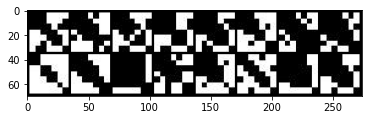

tensor([1., 6., 3., 5., 4., 0., 2.], dtype=torch.float64) tensor([4., 1., 0., 6., 5., 3., 2.], dtype=torch.float64) tensor([1., 2., 5., 4., 0., 6., 3.], dtype=torch.float64) tensor([2., 0., 5., 4., 6., 1., 3.], dtype=torch.float64) tensor([1., 4., 0., 6., 5., 3., 2.], dtype=torch.float64) tensor([2., 1., 4., 6., 5., 0., 3.], dtype=torch.float64) tensor([1., 4., 6., 2., 0., 5., 3.], dtype=torch.float64) tensor([5., 2., 1., 0., 6., 4., 3.], dtype=torch.float64) tensor([3., 0., 1., 6., 2., 5., 4.], dtype=torch.float64) tensor([2., 3., 5., 6., 0., 1., 4.], dtype=torch.float64) tensor([2., 1., 6., 4., 3., 0., 5.], dtype=torch.float64) tensor([0., 3., 5., 6., 1., 4., 2.], dtype=torch.float64) tensor([1., 4., 0., 6., 5., 2., 3.], dtype=torch.float64) tensor([3., 6., 1., 0., 5., 4., 2.], dtype=torch.float64) tensor([2., 0., 4., 6., 5., 1., 3.], dtype=torch.float64) tensor([2., 3., 1., 5., 6., 4., 0.], dtype=torch.float64)


In [7]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_dataloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % labels[j] for j in range(BATCH_SIZE)))

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, NUMBER_NODES)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [9]:
mse_loss = torch.nn.MSELoss()
mae_loss = torch.nn.L1Loss()

class CustomLoss(torch.nn.Module):
    
    def __init__(self):
        super(CustomLoss,self).__init__()

    def loss_repeated_labels(self, roundedOutput):
      used_labels, counts = torch.unique(roundedOutput, return_counts=True)
      counts = counts.type(torch.DoubleTensor)
      return torch.var(counts, unbiased=False)

    def mse_repeated_labels(self, roundedOutput):
      used_labels, counts = torch.unique(roundedOutput, return_counts=True)
      counts = counts.type(torch.DoubleTensor)
      return mse_loss(counts, torch.ones_like(counts))

    def levenshtein_distance(self, roundedOutput):
      used_labels, counts = torch.unique(roundedOutput, return_counts=True)
      counts = counts.type(torch.DoubleTensor)
      return torch.sum(counts - 1)

    def indexes_mse(self, roundedOutput, true):
      output, inverse_indexes = torch.unique(roundedOutput, return_inverse=True)
      true_output, true_inverse_indexes = torch.unique(true, return_inverse=True)
      true_inverse_indexes = true_inverse_indexes.type(torch.DoubleTensor)
      inverse_indexes = inverse_indexes.type(torch.DoubleTensor)
      return mse_loss(true_inverse_indexes, inverse_indexes)
      
    def forward(self, output, target):
      loss_mae = mae_loss(output, target)
      roundedOutput = output.round()
      loss_repeated = self.loss_repeated_labels(roundedOutput)
      levenshtein = self.levenshtein_distance(roundedOutput)
      mse_ones_like = self.mse_repeated_labels(roundedOutput)
      mseIndexes = self.indexes_mse(roundedOutput, target)
      return loss_mae + loss_repeated + mse_ones_like + mseIndexes

In [10]:
criterion = CustomLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

In [11]:
def train(dataloader, model, optimizer):
    train_loss = 0
    for x, y in dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return (train_loss / len(dataloader))

def validation(dataloader, model):
    val_loss = 0
    for X, y in dataloader:
        pred = model(X)
        loss = criterion(pred, y)
        val_loss += loss.item()

    return (val_loss / len(dataloader))

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding='same')
        # pool
        self.conv3 = nn.Conv2d(32, 64, 3, padding='same')
        # pool
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
epochs = 128

model = Net()

list_train_loss = []
list_val_loss = []

for epoch in range(epochs):
    train_loss = train(train_dataloader, model, optimizer)
    list_train_loss.append(train_loss)
    val_loss = validation(test_dataloader, model)
    list_val_loss.append(val_loss)
    print(f'Epoch {epoch + 1}, train_loss: {train_loss}, val_loss: {val_loss}')


Epoch 1, train_loss: 12156.931409562787, val_loss: 11960.762028872967
Epoch 2, train_loss: 12156.931411281708, val_loss: 11960.762028872967
Epoch 3, train_loss: 12156.931365555332, val_loss: 11960.762028872967
Epoch 4, train_loss: 12156.931305081614, val_loss: 11960.762028872967
Epoch 5, train_loss: 12156.931322128543, val_loss: 11960.762028872967
Epoch 6, train_loss: 12156.931378664509, val_loss: 11960.762028872967
Epoch 7, train_loss: 12156.931313380119, val_loss: 11960.762028872967
Epoch 8, train_loss: 12156.931382609951, val_loss: 11960.762028872967
Epoch 9, train_loss: 12156.931399472298, val_loss: 11960.762028872967
Epoch 10, train_loss: 12156.931326420077, val_loss: 11960.762028872967
Epoch 11, train_loss: 12156.931320559594, val_loss: 11960.762028872967
Epoch 12, train_loss: 12156.931331215366, val_loss: 11960.762028872967
Epoch 13, train_loss: 12156.931338152577, val_loss: 11960.762028872967
Epoch 14, train_loss: 12156.931341948048, val_loss: 11960.762028872967
Epoch 15, train

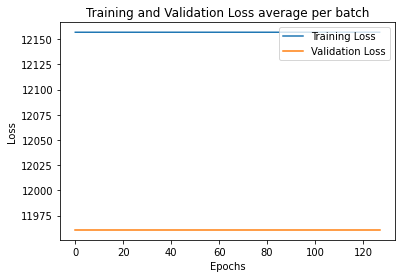

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(list_train_loss, label='Training Loss')
plt.plot(list_val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss average per batch')
# plt.savefig(os.path.join(os.path.dirname(__file__), 'loss.jpg'))
plt.show()
plt.clf()

In [15]:
def count_repeats(output):
    counts = np.unique(np.round(output))
    repeated = NUMBER_NODES - counts.shape[0]
    return repeated

def get_valid_pred(pred):
    valid = np.ones(7)
    labels = np.arange(0, 7)
    for i in labels:
        min_value = np.amin(pred)
        min_idx = np.where(pred == min_value)
        pred[min_idx] = 100
        valid[min_idx] = i
    return valid
    
def get_bandwidth(Graph, nodelist):
    Graph = nx.Graph(Graph)
    if not Graph.edges:
        return 0
    if nodelist.all() != None:
        L = nx.laplacian_matrix(Graph, nodelist=nodelist)
    else:
        L = nx.laplacian_matrix(Graph)
    x, y = np.nonzero(L)
    return (x-y).max()

def getGraph(upperTriangleAdjMatrix):
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    k = 0
    for i in range(NUMBER_NODES):
        for j in range(NUMBER_NODES):
            if i == j:
                continue
            elif i < j:
                dense_adj[i][j] = upperTriangleAdjMatrix[k]
                k += 1
            else:
                dense_adj[i][j] = dense_adj[j][i]
    return dense_adj

def getLength(dataloader):
    length = 0 
    for batch in dataloader:
        length += batch[0].shape[0]
    return length

def get_array_from_image(graph):
    graphnp = graph.numpy()
    graphnp = np.transpose(graphnp, (1, 2, 0))
    graphnp = graphnp.astype(np.uint8)
    graphnp *= 255
    img = Image.fromarray(graphnp, 'RGB')
    img = img.convert('L')
    resized = img.resize((7, 7), Image.NEAREST)
    image_input_np = np.array(resized)
    return image_input_np / 255

In [16]:
sumTest_original = 0
sumTest_pred = 0
sumTest_true = 0

count = 0
cases_with_repetition = 0

for features, target in test_dataloader:
    pred = net(features)
    for i in range(len(pred)):
        output = pred[i]
        output = output.detach().numpy()
        true = target[i].detach().numpy()
        quantity_repeated = count_repeats(np.round(output))
        print('Pred: ', output)
        print('True: ', true)
        if quantity_repeated != 0:
            cases_with_repetition += 1
        output = get_valid_pred(output)
        print('Pred valid: ', output)
        count += quantity_repeated

        graph = get_array_from_image(features[i])
        original_band = get_bandwidth(graph, np.array(None))
        sumTest_original += original_band
        pred_band = get_bandwidth(graph, output)
        sumTest_pred += pred_band
        true_band = get_bandwidth(graph, true)
        sumTest_true += true_band
        print("Bandwidth")
        print(original_band)
        print(pred_band)
        print(true_band)
print('Quantidade de rótulos repetidos, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 6 - ', count)
print('Quantidade de saídas com repetição, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 1 - ', cases_with_repetition)
test_length = getLength(test_dataloader)
print('Test length - ', test_length)
print("Bandwidth mean")
print(sumTest_original / test_length)
print("Pred bandwidth mean")
print(sumTest_pred / test_length)
print("True bandwidth mean")
print(sumTest_true / test_length)

Pred:  [-0.06387861 -0.08358895 -0.02754712  0.03007556 -0.06255302  0.0735046
 -0.02548281]
True:  [1. 5. 6. 0. 3. 2. 4.]
Pred valid:  [1. 0. 3. 5. 2. 6. 4.]
Bandwidth
6
5
2
Pred:  [-0.06334415 -0.08033472 -0.02530174  0.0322056  -0.062585    0.0726513
 -0.01989415]
True:  [3. 0. 6. 4. 5. 2. 1.]
Pred valid:  [1. 0. 3. 5. 2. 6. 4.]
Bandwidth
5
3
3
Pred:  [-0.06627727 -0.08315789 -0.02557494  0.02785429 -0.06158946  0.07591418
 -0.02676263]
True:  [1. 5. 6. 0. 2. 4. 3.]
Pred valid:  [1. 0. 4. 5. 2. 6. 3.]
Bandwidth
5
5
2
Pred:  [-0.06722467 -0.08037337 -0.02418083  0.03056014 -0.06059218  0.07670199
 -0.0228833 ]
True:  [2. 0. 4. 6. 5. 1. 3.]
Pred valid:  [1. 0. 3. 5. 2. 6. 4.]
Bandwidth
5
5
2
Pred:  [-0.06743205 -0.08178419 -0.02771725  0.0271552  -0.06001429  0.0774636
 -0.02163698]
True:  [1. 2. 6. 4. 0. 5. 3.]
Pred valid:  [1. 0. 3. 5. 2. 6. 4.]
Bandwidth
6
5
2
Pred:  [-0.06448721 -0.08258814 -0.02642991  0.03069801 -0.06313401  0.07670324
 -0.02342122]
True:  [4. 0. 2. 6. 5. 3. 1.]